# Classfication Evaluation

In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark background')

In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../modules/'))
sys.path.insert(1, os.path.join(sys.path[0], '../data_creation/'))
sys.path.insert(1, os.path.join(sys.path[0], '../networks/'))
sys.path.insert(1, os.path.join(sys.path[0], '../network_trainers/'))

from CNN_DS_BN_C import CNN_DS_BN_C
from CNN_DS_BN_BC import CNN_DS_BN_BC
from Data_Creator_C import Data_Creator_C
from data_manipulation import *
import tensorflow as tf

In [3]:
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [4]:
training_redundant_baselines_dict, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())
training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

## Load in data

In [5]:
def make_A_from_list_o_sep_pairs(list_o_sep_pairs, max_ant): 
    def get_A_row(two_seps, max_ant_idx):
        """Contructs a row of A by placing a 1 or -1 in the index corresponding to an antenna"""

        a = np.array(two_seps).flatten()

        b = np.zeros((a.size, max_ant_idx), dtype = int)

        b[np.arange(a.size),a] = 1
        b[1] *= -1
        b[2] *= -1

        return np.sum(b, axis = 0)
    
    max_ant_idx = max_ant + 1
    A = []
    for two_seps in list_o_sep_pairs:
        
        A.append(get_A_row(two_seps, max_ant_idx = max_ant_idx))

    return np.asarray(A).reshape(-1, max_ant_idx)

In [50]:
# Find all the different antennas for this data set and extract the max value
unique_ants = []
# for sep_pair in evaluation_seps:     
for key in testing_redundant_baselines_dict.keys():
    for sep in testing_redundant_baselines_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)
max_ant = np.max(unique_ants)       

In [51]:
generated_ant_delays = {ant : np.random.uniform(low = -0.010, high = 0.010) for ant in unique_ants}

In [52]:
_bl_data = testing_baselines_data

In [53]:
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [54]:
_bl_dict = testing_redundant_baselines_dict

In [55]:
_gains = gains

In [56]:
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

In [57]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [58]:
def get_target(two_seps, d):
    return np.sum([d[ant] for ant in np.array(two_seps).flatten()])

In [59]:
num_V_ratios = 2500
inputs = []
targets = []
evaluation_seps = []
nu = np.arange(1024)
for i in range(num_V_ratios):
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    evaluation_seps.append(two_seps)
        
    
    target = get_target(two_seps, generated_ant_delays)
    targets.append(target)

    input_rect = np.angle( _flatness(two_seps)*np.exp(-2j*np.pi*(nu*target + np.random.uniform())))
    
    
    inputs.append(input_rect[np.random.randint(60)])

In [122]:
classes = np.arange(0,0.04 + 0.0005, 0.0005)

In [123]:
rounded_targets = np.asarray([np.round(abs(np.round(d * 20,2)/20), 5) for d in targets]).reshape(-1)

In [124]:
eye = np.eye(len(classes), dtype = int)
classes_labels = {}
for i, key in enumerate(classes):
    classes_labels[np.round(key,5)] = eye[i].tolist()


labels = [classes_labels[x] for x in rounded_targets]

***

## Evaluate magnitude of delay

In [126]:
network = CNN_DS_BN_C('CNN_DS_BN_C_cm_evaluation_test', 2, 81)
network.load_params('../logs/CNN_DS_BN_C_cm_ONETIME4/params/CNN_DS_BN_C')
network.print_params()

params loaded{'adam_initial_learning_rate': 1e-05,
 'log_dir': 'logs/',
 'name': 'CNN_DS_BN_C_cm_evaluation_test',
 'num_classes': 81,
 'num_downsamples': 2}


In [117]:
network.create_graph()

saver = tf.train.Saver()
with tf.Session() as session:

    saver.restore(session,'../logs/CNN_DS_BN_C_cm_ONETIME4/trained_model.ckpt-17')

    eval_feed_dict = {network.X: np.array(inputs).reshape(-1,1,1024,1),
                      network.sample_keep_prob : 1.,
                      network.downsample_keep_prob : 1.,
                      network.is_training : False}

    predicted_labels = session.run([network.predictions], feed_dict = eval_feed_dict)

creating network graph .... ...... doneINFO:tensorflow:Restoring parameters from ../logs/CNN_DS_BN_C_cm_ONETIME4/trained_model.ckpt-17


***
## Evaluate sign of delay

In [118]:
network_pos_neg = CNN_DS_BN_BC('positive_negative_classifier_cm_evaluation_test', 2)
network_pos_neg.load_params('../logs/positive_negative_classifier_cm_extended/params/CNN_DS_BN_BC')

network_pos_neg.create_graph()
saver_pos_neg = tf.train.Saver()
with tf.Session() as session_pos_neg:

    saver_pos_neg.restore(session_pos_neg,'../logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000')
    

    eval_feed_dict_pos_neg = {network_pos_neg.X: np.array(inputs).reshape(-1,1,1024,1),
                              network_pos_neg.sample_keep_prob : 1.,
                              network_pos_neg.downsample_keep_prob : 1.,
                              network_pos_neg.is_training : False}

    predicted_labels_pos_neg = session_pos_neg.run([network_pos_neg.predictions], feed_dict = eval_feed_dict_pos_neg)

creating network graph .... ...... doneINFO:tensorflow:Restoring parameters from ../logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000


### make a dictionary of : 
 {true_delay, top_guesses, probabilites_for_each_guess, {sign_of_guess : probability_of_sign}}

In [127]:
top_num = 3
evaluations = []
# predicted_label_top_picks =  []

for i, a in enumerate(np.array(predicted_labels).reshape(-1,81)):
    
    ind = np.argpartition(a, -top_num)[-top_num:]
    
    picks = []
    percs = []
    for j in ind:
        
        picks.append(classes[j])#np.round(classes[j],5))
        percs.append(np.round(a[j],5))
        
    idx = np.argsort(percs)
    sPerc = predicted_labels_pos_neg[0][i]
    s = {"pos" : np.round(np.max(sPerc),4)} if np.argmax(sPerc) == 0 else {"neg" : np.round(np.max(sPerc),4)}
    
#     predicted_label_top_picks.append((np.round(evaluation_targets[i],6), np.array(picks)[idx][::-1], np.array(percs)[idx][::-1], s))
    
    evaluation = {}
    evaluation['true'] = targets[i]#np.round(evaluation_targets[i],6)
    evaluation['top_3'] = [x for x in np.array(picks)[idx][::-1]]
    evaluation['top_3_probs'] = [x for x in np.array(percs)[idx][::-1]]
    evaluation['sign'] = s
    evaluation['guess'] = evaluation['top_3'][0] if s.keys()[0] == 'pos' else -1*evaluation['top_3'][0]
    evaluation['error'] = evaluation['true'] - evaluation['guess']

    evaluations.append(evaluation)
                                      

### Print some to take a look

In [128]:
from pprint import pprint as pPrint

In [129]:
for x in evaluations[0:5]:
    pPrint(x)
    print('\n')

{'error': 0.0032433921046460825,
 'guess': -0.0015,
 'sign': {'neg': 0.9789},
 'top_3': [0.0015, 0.0, 0.003],
 'top_3_probs': [1.0, 0.0, 0.0],
 'true': 0.0017433921046460825}


{'error': 4.592935923109637e-05,
 'guess': -0.0055,
 'sign': {'neg': 0.9994},
 'top_3': [0.0055, 0.005, 0.0],
 'top_3_probs': [0.9994, 0.0006, 0.0],
 'true': -0.005454070640768903}


{'error': -0.013695287611776926,
 'guess': -0.0,
 'sign': {'neg': 1.0},
 'top_3': [0.0, 0.013000000000000001, 0.0145],
 'top_3_probs': [0.99999, 0.0, 0.0],
 'true': -0.013695287611776926}


{'error': 5.54793634300766e-05,
 'guess': -0.0075,
 'sign': {'neg': 1.0},
 'top_3': [0.0075, 0.0, 0.008],
 'top_3_probs': [1.0, 0.0, 0.0],
 'true': -0.007444520636569923}


{'error': -0.008751396490326855,
 'guess': -0.0,
 'sign': {'neg': 0.9998},
 'top_3': [0.0, 0.018000000000000002, 0.008],
 'top_3_probs': [0.99995, 4e-05, 0.0],
 'true': -0.008751396490326855}




In [130]:
errors = [x['error'] for x in evaluations]
best_guesses = [x['guess'] for x in evaluations]
combined_prob = [x['top_3_probs'][0]*x['sign'].values()[0] for x in evaluations]

In [131]:
print('Out of a maximum score of {}, this dataset scores {}'.format(len(evaluations), sum(combined_prob)))

Out of a maximum score of 2500, this dataset scores 2279.62153968


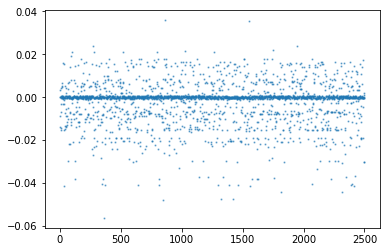

std(error) = 0.00937193354312
percent of errors less than 0.0005 (~5ns)= 0.7584


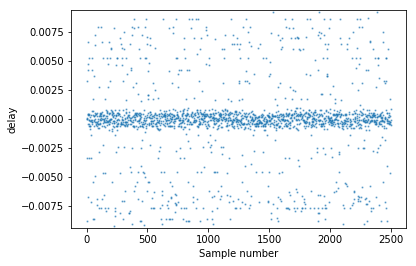

In [132]:
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.show()
print('std(error) = {}'.format(np.std(errors)))
print('percent of errors less than 0.0005 (~5ns)= {}'.format(np.mean(np.asarray(errors) < 0.0005)))
plt.xlabel('Sample number')
plt.ylabel('delay')
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.ylim(-np.std(errors),np.std(errors))
plt.xlabel('Sample number')
plt.ylabel('delay')
plt.show()

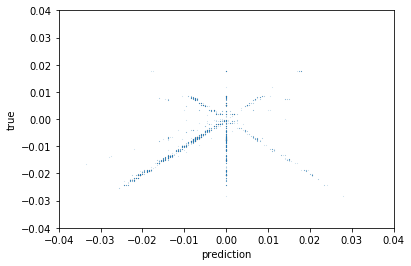

In [155]:
plt.plot(best_guesses, targets, ls = 'none', marker = 's', markersize = .1, alpha = 0.5);
plt.xlim(-0.040, 0.040)
plt.ylim(-0.040, 0.040)
plt.xlabel('prediction')
plt.ylabel('true');

***

## Assuming these results are ok, can we solve Ax = b and get realistic results?

In [134]:
# Create A
A = make_A_from_list_o_sep_pairs(evaluation_seps, max_ant )

### take a look at A.

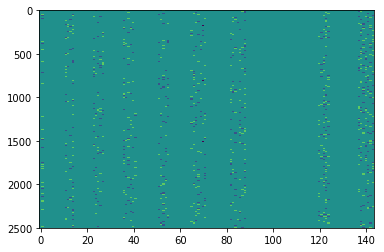

In [135]:
plt.imshow(A, aspect = 'auto');

In [136]:
# drop the empty columns ( the antennas not present)
# dont do and  indexing  will be easier
# A = A[:, unique_ants]

In [137]:
# create b
b = np.array(best_guesses)

Solve Ax = b

In [138]:
# solve
x = np.linalg.lstsq(A, b, rcond=None)[0]

In [139]:
# suppress scientific notation
np.set_printoptions(suppress=True)

In [140]:
x

array([ 0.        , -0.00120301, -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.00127093,  0.00033153,  0.00061513, -0.00002576,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.00125134, -0.00120603,
        0.00033374, -0.00008863, -0.00026242, -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.00038362,  0.00032389, -0.0016423 ,  0.00045111,
       -0.00004055, -0.00174792,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00113658, -0.00058062,  0.0011392 ,  0.00018647,
        0.00027709,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00038399, -0.00033593,  0.00070497,  0.00351882, -0.00

In [141]:
solution = {i : x[i] for i in range(len(x))}

In [142]:
keys = sorted(generated_ant_delays.keys())
sols = [solution[key] for key in keys]
trus = [generated_ant_delays[key] for key in keys]
errs = np.array(trus) - np.array(sols)

In [143]:
print(np.std(errs))
print(np.mean(errs))
print(np.median(errs))

0.005077810792830222
-0.0018710654398084055
-0.002343855951541761


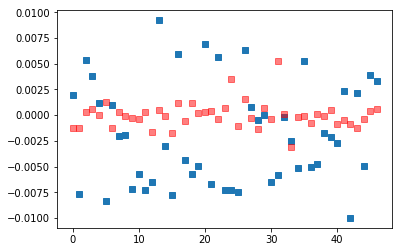

In [144]:
plt.plot(np.arange(len(sols)), trus,ls = 'none', marker = 's')
plt.plot(np.arange(len(sols)), sols,ls = 'none', marker = 's', c = 'r', alpha = 0.5)

Should we weight AX = b? if so by what?

***
combined_prob as Weights 🤷🏻‍♂️

Solve wAx = wb

In [145]:
w = np.diag(1/(np.array(combined_prob)))

In [146]:
wb = np.dot(w,b)

In [147]:
wA = np.dot(w,A)

In [148]:
wx = np.linalg.lstsq(wA, wb, rcond=None)[0]

In [149]:
wx

array([ 0.        , -0.00148564,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.00027023,  0.00079359,  0.00013149,  0.00003685,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.00187861, -0.00198795,
        0.00042602, -0.0002407 , -0.00001199, -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.00040668,  0.00051576, -0.00151146,  0.00031298,
       -0.00036291, -0.00183954,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00100927, -0.00196279,  0.00135383, -0.00043824,
        0.00061141,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.000948  , -0.00068249,  0.00135162,  0.00355544, -0.00

In [150]:
solution = {i : wx[i] for i in range(len(wx))}

In [151]:
keys = sorted(generated_ant_delays.keys())
sols = [solution[key] for key in keys]
trus = [generated_ant_delays[key] for key in keys]
errs = np.array(trus) - np.array(sols)

In [152]:
print(np.std(errs))
print(np.mean(errs))
print(np.median(errs))

0.005091943592451404
-0.0018710654398084062
-0.002348241614895073


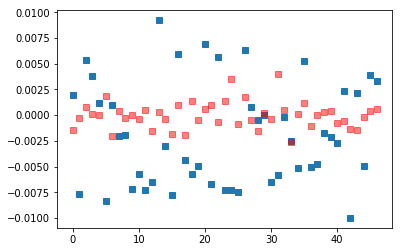

In [153]:
plt.plot(np.arange(len(sols)), trus,ls = 'none', marker = 's')
plt.plot(np.arange(len(sols)), sols,ls = 'none', marker = 's', c = 'r', alpha = 0.5)

In [ ]:
``````````````````````````````````````